In [153]:
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.stats import chi2, ttest_rel
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from dataloader import FastTensorDataLoader

## 1d Gaussian Score Matching

In [2]:
class Gaussian_1d(nn.Module):
    def __init__(self):
        super(Gaussian_1d, self).__init__()
        self.mu = nn.Parameter(torch.randn(1, dtype=torch.float64))
        self.sigma = nn.Parameter(torch.abs(torch.randn(1, dtype=torch.float64)))

    def forward(self, x):
        diff = x - self.mu
        return -0.5 * (diff**2/self.sigma**2)

In [ ]:
def compute_psi_1d(x, model):
    x.requires_grad_()
    nn_output = model(x)
    psi = torch.autograd.grad(nn_output, x, create_graph=True)[0]
    return psi

In [4]:
def J_1d(x_t, model):
    T = len(x_t)
    total_sum, real_sum = 0, 0

    for t in range(T):
        x = x_t[t]
        psi_x = compute_psi_1d(x, model)
        psi_x_real = - (x - model.mu)/model.sigma**2

        divergence = torch.autograd.grad(psi_x.sum(), x, create_graph=True)[0].sum()
        divergence_real = -1/model.sigma**2
        norm_squared = (psi_x ** 2).sum()
        norm_squared_real = (psi_x_real ** 2).sum()

        real_sum += 0.5 * norm_squared_real + divergence_real
        total_sum += 0.5 * norm_squared + divergence

    return total_sum / T, real_sum / T

In [5]:
def optimize_theta_gaussian_1d(
    x_t_all, num_epochs=1000, learning_rate=1e-3,
    display_loss=True,
):
    model = Gaussian_1d()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses, real_losses = [], []
    estimated_mus = []
    estimated_stds = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        x_t_tensor = x_t_all.clone().detach().to(dtype=torch.float32)
        loss, real_loss = J_1d(x_t_tensor, model)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        real_losses.append(real_loss.item())
        estimated_mus.append(model.mu.detach().numpy().copy())
        estimated_stds.append(model.sigma.detach().numpy().copy())

        if display_loss:
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_mus, estimated_stds

In [6]:
mean, std = 0, 1
x = torch.normal(mean=mean, std=std, size=(1000,))

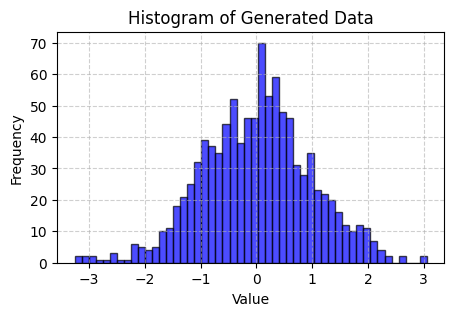

In [7]:
plt.figure(figsize=(5, 3))
plt.hist(x.numpy(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Generated Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [8]:
epochs = 50
model, losses, real_losses, estimated_mu, estimated_std = optimize_theta_gaussian_1d(
    x, num_epochs=epochs, learning_rate=1e-2)

Epoch 0/50, Loss: 10685.767578125
Epoch 1/50, Loss: 7375.88037109375
Epoch 2/50, Loss: 4912.52099609375
Epoch 3/50, Loss: 3156.41455078125
Epoch 4/50, Loss: 1956.7535400390625
Epoch 5/50, Loss: 1170.7398681640625
Epoch 6/50, Loss: 676.2064208984375
Epoch 7/50, Loss: 377.0192565917969
Epoch 8/50, Loss: 202.74453735351562
Epoch 9/50, Loss: 104.9144287109375
Epoch 10/50, Loss: 51.981510162353516
Epoch 11/50, Loss: 24.40801429748535
Epoch 12/50, Loss: 10.628066062927246
Epoch 13/50, Loss: 4.0722270011901855
Epoch 14/50, Loss: 1.1515530347824097
Epoch 15/50, Loss: -0.021769041195511818
Epoch 16/50, Loss: -0.40285760164260864
Epoch 17/50, Loss: -0.45456430315971375
Epoch 18/50, Loss: -0.4754204750061035
Epoch 19/50, Loss: -0.49150216579437256
Epoch 20/50, Loss: -0.49712929129600525
Epoch 21/50, Loss: -0.5183924436569214
Epoch 22/50, Loss: -0.5152369141578674
Epoch 23/50, Loss: -0.5152369141578674
Epoch 24/50, Loss: -0.5215902924537659
Epoch 25/50, Loss: -0.5163215398788452
Epoch 26/50, Loss:

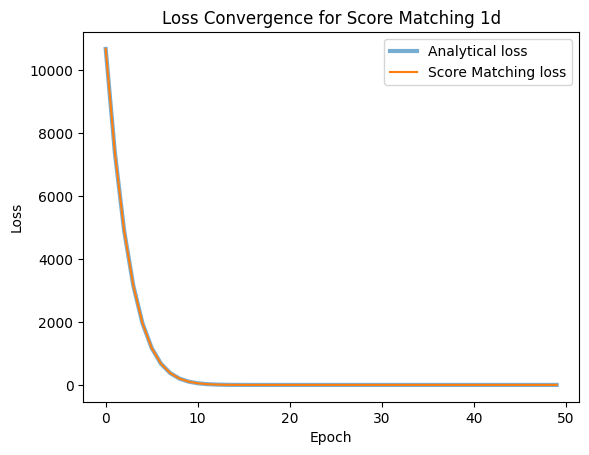

In [12]:
plt.plot(real_losses, linewidth=3, alpha=0.6, label="Analytical loss")
plt.plot(losses, label="Score Matching loss", linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching 1d')
plt.legend()
plt.show()

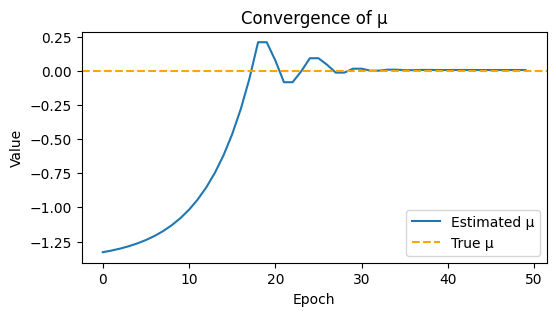

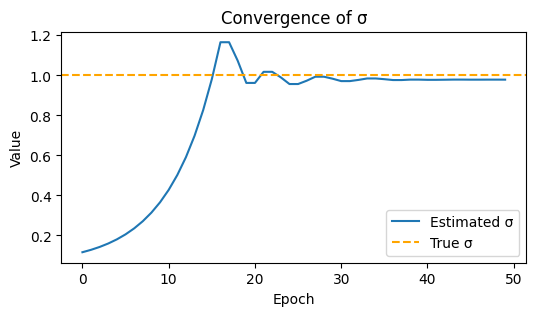

In [13]:
plt.figure(figsize=(6, 3))
plt.plot(estimated_mu, label="Estimated μ")
plt.axhline(mean, color='orange', linestyle='--', label="True μ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ')
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(estimated_std, label="Estimated σ")
plt.axhline(std, color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [ ]:
print("Final estimated μ:", estimated_mu[-1][0])
print("True μ:", mean)
print("\nFinal estimated σ:\n", estimated_std[-1][0])
print("True σ:\n", std)

Final estimated μ: 0.0056332769506071715
True μ: 0

Final estimated σ:
 0.9787437415365288
True σ:
 1


### Statistical Testing

In [ ]:
num_trials = 5
epochs = 50
learning_rate = 1e-2

true_mu = []
true_cov = []
estimated_mu = []
estimated_cov = []

In [7]:
json_file = 'data/trial_results.json'

In [ ]:
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        trial_results = json.load(f)
else:
    trial_results = []

for trial in tqdm(range(num_trials), desc="Running trials"):
    mean = np.random.uniform(1, 5)
    std = np.random.uniform(1, 3)
    
    x = torch.normal(mean=mean, std=std, size=(1000,))
    
    _, _, _, estimated_mu, estimated_std = optimize_theta_gaussian_1d(
        x, num_epochs=epochs, learning_rate=learning_rate, display_loss=False)
    trial_result = {
        "trial": trial,
        "epochs": epochs,
        "lr": learning_rate,
        "true_mean": mean,
        "true_std": std,
        "estimated_mean": estimated_mu[-1][0].item(),
        "estimated_std": estimated_std[-1][0].item()
    }
    trial_results.append(trial_result)
    
    with open(json_file, mode='w') as f:
        json.dump(trial_results, f, indent=4)

Running trials:   0%|          | 0/5 [00:00<?, ?it/s]

Running trials: 100%|██████████| 5/5 [08:12<00:00, 98.54s/it] 


In [8]:
with open(json_file, mode='r') as f:
    trial_results = json.load(f)

true_mu = np.array([trial['true_mean'] for trial in trial_results])
true_cov = np.array([trial['true_std'] for trial in trial_results])
estimated_mu = np.array([trial['estimated_mean'] for trial in trial_results])
estimated_cov = np.array([trial['estimated_std'] for trial in trial_results])

In [9]:
mean_ttest = ttest_rel(true_mu, estimated_mu)
std_ttest = ttest_rel(true_cov, estimated_cov)

print(f"Mean difference (paired t-test): p-value = {mean_ttest.pvalue}")
print(f"Variance difference (paired t-test): p-value = {std_ttest.pvalue}")

alpha = 0.05
if mean_ttest.pvalue < alpha:
    print("The model produces statistically significant differences in estimated means.")
else:
    print("No statistically significant difference in estimated means.")

if std_ttest.pvalue < alpha:
    print("The model produces statistically significant differences in estimated variances.")
else:
    print("No statistically significant difference in estimated variances.")

Mean difference (paired t-test): p-value = 0.2401774175176807
Variance difference (paired t-test): p-value = 0.30769906430455984
No statistically significant difference in estimated means.
No statistically significant difference in estimated variances.


## Multivariate Gaussian Score Matching

### Data Generation

In [124]:
def generate_multivariate_gaussian_data(mean, cov, num_samples):
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

In [246]:
samples = []

# mu = np.array([0.0, 0.0])
# cov = np.array([[1.0, 0.0], [0.0, 1.0]])
mu = np.random.uniform(-1, 1, size=(2,))    
random_matrix = np.random.rand(2, 2)
cov = np.dot(random_matrix.T, random_matrix)

n = 100
for _ in range(n):
    sample = generate_multivariate_gaussian_data(mu, cov, 1000) 
    samples.append(torch.tensor(sample))
dim = samples[-1].shape[1]

In [247]:
X = torch.stack(samples, dim=0)
X_train = X[:100]
X_val = X[100:150]
loader_train = FastTensorDataLoader(X_train, batch_size=1000, shuffle=False)
loader_val = FastTensorDataLoader(X_val, batch_size=1000, shuffle=False)

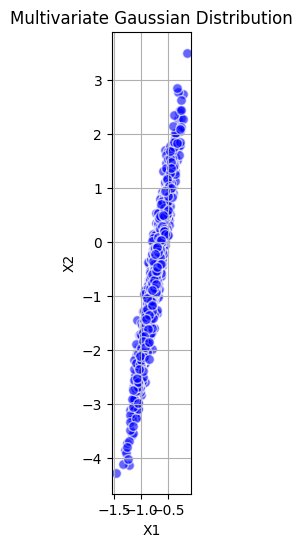

In [248]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train[0][:, 0], X_train[0][:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Gaussian Model

In [249]:
class Gaussian(nn.Module):
    def __init__(self, dimensions):
        super(Gaussian, self).__init__()
        # torch.manual_seed(123)
        self.mu = nn.Parameter(torch.randn(dimensions, dtype=torch.float64))
        self.M = nn.Parameter(torch.randn(size=[dimensions, dimensions], dtype=torch.float64))
        A = torch.randn(dimensions, dimensions, dtype=torch.float64)
        self.M = nn.Parameter(torch.mm(A, A.T))    
        self.M.data += dimensions * torch.eye(dimensions, dtype=torch.float64)
        
    def forward(self, x):
        diff = x - self.mu
        return -0.5 * torch.einsum('bpi,ij,bpj->bp', diff, self.M, diff)

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi
    
    def gaussian_psi(self, x):
        diff = x - self.mu
        return -torch.einsum('ij,bpj->bpi', self.M, diff)
    
    def gaussian_J(self, x, length):
        diff = x - self.mu
        trace_term = -torch.trace(self.M)
        quadratic_term = torch.einsum('bpi,ij,bpj->bp', diff, self.M @ self.M, diff)

        J_value = 0.5*quadratic_term + trace_term
        J_value = J_value.sum(dim=-1) / length

        return J_value.mean()
    
    def loss(self, x):
        length = len(x[0])
        psi_x = self.compute_psi(x)
        psi_x_real = self.gaussian_psi(x)
        if not torch.allclose(psi_x, psi_x_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x} \
                is different from the analytical solution {psi_x_real}"
                )

        norm_squared = (psi_x ** 2).sum(dim=-1) 

        divergence = 0
        for i in range(x.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/length  # Sum over the time dimension
        total_loss = total_loss.mean()

        J = self.gaussian_J(x, length)
        if not torch.allclose(total_loss, J, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {total_loss} \
                is different from the analytical solution {J}"
                )
        
        return total_loss, J
        

### Optimization Loop

In [250]:
def optimize_theta_gaussian(
        loader_train, dim, num_epochs=1000, learning_rate_mu=1e-3,
        learning_rate_M=1e-4, display_loss=True,
    ):
    model = Gaussian(dim)
    optimizer = torch.optim.Rprop(
        [
            {"params": [model.mu], "lr": learning_rate_mu},
            {"params": [model.M], "lr": learning_rate_M},
        ]
    )
    losses = []
    real_losses = []
    estimated_mus = []
    estimated_covs = []

    for epoch in range(num_epochs):
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss, real_loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            real_losses.append(real_loss.item())
            estimated_mus.append(model.mu.detach().numpy().copy())
            estimated_covs.append(model.M.detach().numpy().copy())

            if display_loss:
                print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_mus, estimated_covs

### Training Loop

In [256]:
start_time = time.time()
epochs = 100
model, losses, real_losses, estimated_mus, estimated_cov = optimize_theta_gaussian(
    loader_train, dim, num_epochs=epochs, learning_rate_mu=1e-3, learning_rate_M=1e-3,
    )
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Epoch 0/100, Loss: 58.68864148203936
Epoch 1/100, Loss: 58.65506857745031
Epoch 2/100, Loss: 58.61503300423512
Epoch 3/100, Loss: 58.567352561215905
Epoch 4/100, Loss: 58.51065678336265
Epoch 5/100, Loss: 58.44337021786837
Epoch 6/100, Loss: 58.36370136906349
Epoch 7/100, Loss: 58.269642270557895
Epoch 8/100, Loss: 58.15898621527209
Epoch 9/100, Loss: 58.02937488250993
Epoch 10/100, Loss: 57.878391393892315
Epoch 11/100, Loss: 57.6992070873547
Epoch 12/100, Loss: 57.48422580614736
Epoch 13/100, Loss: 57.227587162860324
Epoch 14/100, Loss: 56.92153333843158
Epoch 15/100, Loss: 56.55699626922397
Epoch 16/100, Loss: 56.12343388530342
Epoch 17/100, Loss: 55.60867128857536
Epoch 18/100, Loss: 54.998760606169405
Epoch 19/100, Loss: 54.27787903842126
Epoch 20/100, Loss: 53.42829126313738
Epoch 21/100, Loss: 52.430408964155774
Epoch 22/100, Loss: 51.262984873752266
Epoch 23/100, Loss: 49.90347775420864
Epoch 24/100, Loss: 48.32861236774994
Epoch 25/100, Loss: 46.51512673343274
Epoch 26/100, Lo

### Loss and Parameters Plots

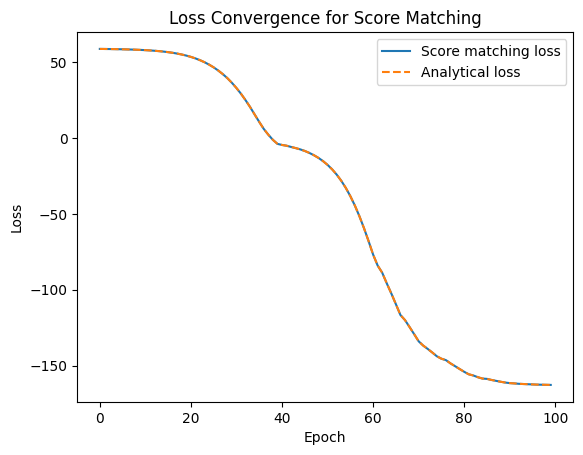

In [257]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, label="Analytical loss", linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()

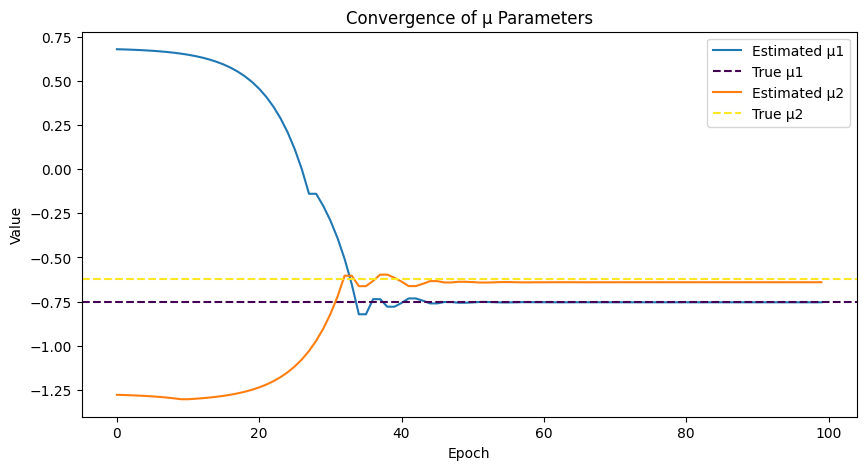

C:\Users\79217\AppData\Local\Temp\ipykernel_5520\4213944928.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  estimated_covs_array = np.array(torch.linalg.inv(torch.tensor(estimated_cov)))


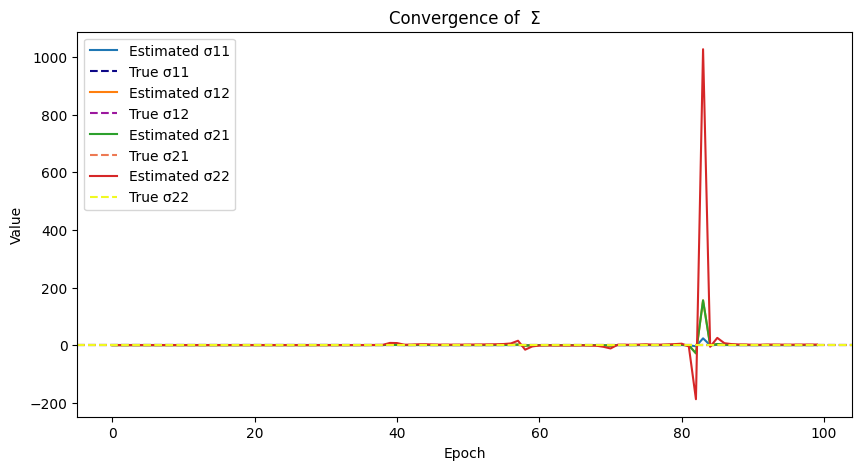

In [258]:
estimated_mus = np.array(estimated_mus)  # (epochs, d)
d = estimated_mus.shape[1]
colors_mu = plt.cm.viridis(np.linspace(0, 1, d))

plt.figure(figsize=(10, 5))
for i in range(d):
    plt.plot(estimated_mus[:, i], label=f"Estimated μ{i+1}")
    plt.axhline(
        mu[i] + 0.001 * (i + 1), 
        linestyle='--', color=colors_mu[i], label=f"True μ{i+1}")

plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of μ Parameters')
plt.show()

estimated_covs_array = np.array(torch.linalg.inv(torch.tensor(estimated_cov)))
epochs, d, _ = estimated_covs_array.shape


colors_cov = plt.cm.plasma(np.linspace(0, 1, d * d))
color_map = np.reshape(colors_cov, (d, d, 4))
jitter = 0.01
plt.figure(figsize=(10, 5))
for i in range(d):
    for j in range(d):
        plt.plot(estimated_covs_array[:, i, j], label=f"Estimated σ{i+1}{j+1}")
        if i == j:  # Diagonal elements 
            plt.axhline(cov[i, j] + jitter * (1 if i % 2 == 0 else -1), linestyle='--', color=color_map[i, j], label=f"True σ{i+1}{j+1}")
        elif i < j:  # Off-diagonal unique pairs 
            plt.axhline(cov[i, j] + jitter, linestyle='--', color=color_map[i, j], label=f"True σ{i+1}{j+1}")
        else:  # Symmetric off-diagonal elements
            plt.axhline(cov[i, j] - jitter, linestyle='--', color=color_map[i, j], label=f"True σ{i+1}{j+1}")


plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of  Σ')
plt.show()

### Final Parameter estimations

In [259]:
print("Final estimated μ:", estimated_mus[-1])
print("True μ:", mu)
print("\nFinal estimated Σ:\n", torch.linalg.inv(torch.tensor(estimated_cov[-1])))
print("True Σ:\n", cov)

Final estimated μ: [-0.75395592 -0.64037463]
True μ: [-0.75135999 -0.62193074]

Final estimated Σ:
 tensor([[0.0467, 0.2840],
        [0.2840, 1.8593]], dtype=torch.float64)
True Σ:
 [[0.04287036 0.25899457]
 [0.25899457 1.68866945]]


In [ ]:
model_mu = torch.tensor(estimated_mus[-1])
model_cov = torch.linalg.inv(torch.tensor(estimated_cov[-1]))
model_x_t = generate_multivariate_gaussian_data(model_mu, model_cov, n)

C:\Users\79217\AppData\Local\Temp\ipykernel_7676\2233108499.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  data = np.random.multivariate_normal(mean, cov, num_samples)


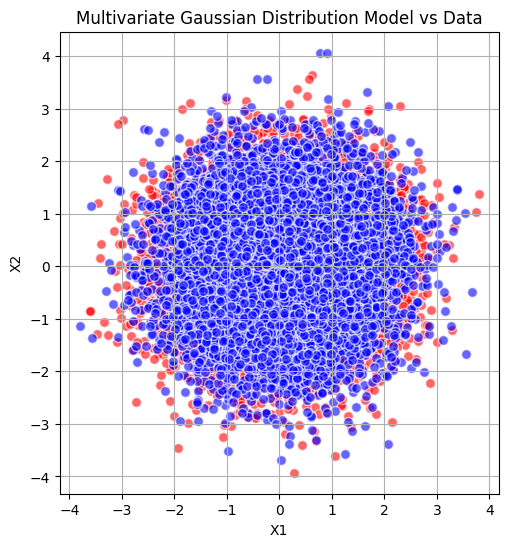

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(model_x_t[:, 0], model_x_t[:, 1], c='red', alpha=0.6, edgecolors='w', s=50)

plt.scatter(x_t_all[:, 0], x_t_all[:, 1], c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title("Multivariate Gaussian Distribution Model vs Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

### Statistical Significance

In [277]:
num_trials = 100
epochs = 500
learning_rate_mu = 1e-3
learning_rate_M = 1e-3

In [276]:
true_mu = []
true_cov = []
estimated_mu = []
estimated_cov = []

In [278]:
json_file = f'data/trial_results_2d_epochs_{epochs}.json'

In [271]:
if os.path.exists(json_file):
    with open(json_file, 'r') as f:
        trial_results = json.load(f)
else:
    trial_results = []

n = 1000 # trials
m = 100 # samples per trial
num_points = 1000
for trial in tqdm(range(num_trials), desc="Running trials"):
    mu = np.random.uniform(-1, 1, size=(2,))    
    random_matrix = np.random.rand(2, 2)
    cov = np.dot(random_matrix.T, random_matrix)

    samples = []
    for _ in range(m):
        sample = generate_multivariate_gaussian_data(mu, cov, num_points) 
        samples.append(torch.tensor(sample))
    dim = samples[-1].shape[1]
    X_train = torch.stack(samples, dim=0)
    loader_train = FastTensorDataLoader(X_train, batch_size=1000, shuffle=False)
    
    _, _, _, estimated_mu, estimated_cov = optimize_theta_gaussian(
        loader_train, dim, num_epochs=epochs,
        learning_rate_mu=learning_rate_mu,
        learning_rate_M=learning_rate_M,
        display_loss=False)
    
    trial_result = {
        "trial": trial,
        "epochs": epochs,
        "lr_mu": learning_rate_mu,
        "lr_M": learning_rate_M,
        "true_mu": mu.tolist(),
        "true_cov": cov.tolist(),
        "estimated_mu": estimated_mu[-1].tolist(),
        "estimated_cov": torch.linalg.inv(torch.tensor(estimated_cov[-1])).tolist(),
    }
    trial_results.append(trial_result)
    
    with open(json_file, mode='w') as f:
        json.dump(trial_results, f, indent=4)

Running trials:   0%|          | 0/100 [00:00<?, ?it/s]

Running trials: 100%|██████████| 100/100 [42:23<00:00, 25.43s/it]


In [279]:
with open(json_file, mode='r') as f:
    trial_results = json.load(f)

true_mu = np.array([trial['true_mu'] for trial in trial_results])
true_cov = np.array([trial['true_cov'] for trial in trial_results])
estimated_mu = np.array([trial['estimated_mu'] for trial in trial_results])
estimated_cov = np.array([trial['estimated_cov'] for trial in trial_results])

In [280]:
p = 2  

# Compute Mahalanobis distances
D_squared = []
for i in range(num_trials):
    mean_diff = estimated_mu[i] - true_mu[i]
    cov_inv = np.linalg.inv(true_cov[i])
    D2 = np.dot(np.dot(mean_diff.T, cov_inv), mean_diff)  # Mahalanobis distance squared
    D_squared.append(D2)

D_squared = np.array(D_squared)

# Perform Chi-Squared Test
chi2_critical = chi2.ppf(0.95, df=p)  # Critical value for 95% confidence
significant_indices = np.where(D_squared > chi2_critical)[0]
significant_trials = np.sum(D_squared > chi2_critical)  # Count significant deviations
p_values = 1 - chi2.cdf(D_squared, df=p)  # Compute p-values for each trial

print(f"Number of significant trials: {significant_trials}/{num_trials}")
print(f"Mean p-value: {np.mean(p_values)}")

if significant_trials > 0:
    print("There are statistically significant deviations in some trials.")
    print("Significant trials details:")
    for idx in significant_indices:
        print(f"Trial {idx}:")
        print(f"  p-value = {p_values[idx]}")
        print(f"  True μ = {true_mu[idx]}")
        print(f"  Estimated μ = {estimated_mu[idx]}")
else:
    print("No statistically significant deviations detected.")

Number of significant trials: 1/100
Mean p-value: 0.9393501495945893
There are statistically significant deviations in some trials.
Significant trials details:
Trial 64:
  p-value = 2.405238366254281e-07
  True μ = [-0.89940677 -0.21407325]
  Estimated μ = [-0.44301769  3.34436098]


In [ ]:
df = p * (p + 1) // 2  # Degrees of freedom for covariance matrix
test_statistics = []

for i in range(num_trials):
    true_det = np.linalg.det(true_cov[i])
    pred_det = np.linalg.det(estimated_cov[i])
    
    # Skip invalid determinants
    if pred_det <= 0:
        print(f"Skipping trial {i}: true_det={true_det}, pred_det={pred_det}")
        continue

    true_inv = np.linalg.inv(true_cov[i])
    trace_term = np.trace(np.dot(true_inv, estimated_cov[i]))
    
    log_det_term = np.log(true_det) - np.log(pred_det)
    test_stat = num_trials * (log_det_term + trace_term - p)  # Compute Lambda
    test_statistics.append(test_stat)

test_statistics = np.array(test_statistics)

p_values = 1 - chi2.cdf(test_statistics, df=df)
significant_indices = np.where(p_values < 0.05)[0]
significant_trials = np.sum(p_values < 0.05)

print(f"Number of significant trials: {significant_trials}/{num_trials}")
print(f"Mean p-value: {np.mean(p_values)}")

if significant_trials > 0:
    print("Some trials show significant differences in covariance matrices.")
    print("Significant trials details:")
    for idx in significant_indices:
        print(f"Trial {idx}:")
        print(f"  p-value = {p_values[idx]}")
        print(f"  True Covariance Matrix =\n{true_cov[idx]}")
        print(f"  Estimated Covariance Matrix =\n{estimated_cov[idx]}")
else:
    print("No significant differences detected in covariance matrices.")

Skipping trial 4: true_det=6.5589781950817e-06, pred_det=-0.001870136687597627
Skipping trial 64: true_det=0.00032370013982154476, pred_det=-0.005378297567723831
Number of significant trials: 16/100
Mean p-value: 0.8105746540004486
Some trials show significant differences in covariance matrices.
Significant trials details:
Trial 6:
  p-value = 0.0
  True Covariance Matrix =
[[0.96035598 0.95439747]
 [0.95439747 1.50798758]]
  Estimated Covariance Matrix =
[[0.95962736 0.95195095]
 [0.95195095 1.50395204]]
Trial 7:
  p-value = 0.0
  True Covariance Matrix =
[[0.43741571 0.8047781 ]
 [0.8047781  1.4818409 ]]
  Estimated Covariance Matrix =
[[0.21255791 0.38955308]
 [0.38955308 0.71968201]]
Trial 8:
  p-value = 0.0
  True Covariance Matrix =
[[1.07889151 0.58061861]
 [0.58061861 0.39299951]]
  Estimated Covariance Matrix =
[[3.48059981 1.95425032]
 [1.95425032 1.17881836]]
Trial 17:
  p-value = 1.2337908472659365e-12
  True Covariance Matrix =
[[1.34333985 1.16505784]
 [1.16505784 1.06402

### Autograd and Analytical Solution comparison

In [ ]:
def compare_grad_jacobian(x, model):
    psi_x_t = model.compute_psi(x)

    divergence_autograd = 0
    for i in range(x.shape[-1]):
        gradient = torch.autograd.grad(psi_x_t[..., i].sum(), x, retain_graph=True, create_graph=True)[0]
        divergence_autograd += gradient[..., i]
        
    divergence_analytical, _ = model.gaussian_J(x)

    return divergence_autograd, divergence_analytical

In [ ]:
model = Gaussian(dim)
x = [1.0856, -0.9973]
x_tensor = torch.tensor(x, dtype=torch.float64, requires_grad=True)
div_a, div_an = compare_grad_jacobian(x_tensor, model)

In [ ]:
print(f"Divergence (autograd): {div_a}")
print(f"Divergence (analytical): {div_an}")

Divergence (autograd): -5.632258052693178
Divergence (Jacobian): -5.632258052693178
Divergence (analytical): -5.632258052693178
